In [2]:
#####   RUN THIS CELL FIRST!   #####
##### IMPORTS ALL REQUIREMENTS #####
#####   & INCLUDES CONSTANTS   #####
import os
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import pearsonr, ttest_1samp
pd.set_option('display.max_columns', None)

# Data Analysis Notebook

## Introduction

write stuff here on what is being done here

## Todo

1. Create table on mean, std, and other metrics for each demographics question.

2. Create a breakdown of overall performance on how people performed on the task.

3. Do an analysis on how different categories (poem, article, etc.) affected performance.

4. Do an analysis of how people performed based on prior knowledge

### Part 1: Data loading

In this section, we are loading the data and parsing it so that we can use it in the data analysis section. We are getting rid of all the unnecessary metadata that qualtrics includes for each response

In [3]:
##### Helper Functions #####
def parse_passage_response(x: str) -> int:
    parse_dict = {
        'Human Written': 0,
        'AI Generated': 1
    }
    
    return parse_dict.get(x, 0)

def parse_sf1_response(x: str) -> int:
    parse_dict = {
        '0': 1,
        '1': 2,
        '2': 3,
        '3': 4,
        '4+': 5,
    }
    
    return parse_dict.get(x, 1)

def parse_sf2_response(x: str) -> int:
    parse_dict = {
        'Rarely or never': 1,
        'A few times a month': 2,
        'Once a week': 3,
        'Several times a week': 4,
        'Daily': 5,
    }
    
    return parse_dict.get(x, 1)

def parse_edu_response(x: str) -> int:
    parse_dict = {
        'High school diploma or GED': 1,
        'Some college, but no degree': 2,
        'Associate Degree': 3,
        'Bachelor\'s Degree': 4,
        'Master\'s Degree or higher education': 5,
        'Other (Please fill in)': 6,
        'Prefer not to say': 0
    }
    
    return parse_dict.get(x, 0)

def parse_ta_response(x: str) -> int:
    if x == 'No':
        return 0
    return 1
    

In [4]:
# Load df
data_path = Path('./data/')
tsv_files = os.listdir(data_path)

print(tsv_files)

dfs = []
starting_value = 0
for tsv_file in tsv_files:
    print(tsv_file)
    new_df = pd.read_csv(data_path/tsv_file, sep='\t', encoding='UTF-16', quoting=3, skiprows=[1,2])
    new_df.index = np.arange(starting_value, starting_value+len(new_df))
    starting_value += len(new_df)
    dfs.append(new_df)

df = pd.concat(dfs)

# Removes extra metadata from dataframe
columns_to_keep = ["Duration (in seconds)", "Finished", "RecordedDate", "ResponseId", "ID", "Consent", "SF1_1", "SF1_2", "SF1_3", "SF2_1", "SF2_2", "SF2_3", "SF2_4", "SF2_5", "SF2_6", "SF2_7", "Age", "Education", "Education_7_TEXT", "Major", "TA Exp", "TA Exp_1_TEXT", "HU-S3", "AI-S1", "HU-P2", "AI-P1", "HU-N2", "AI-N1", "HU-W2", "AI-W3", "Strategy", "Patterns"]
df = df[columns_to_keep].reset_index(drop=True) 

# Keep finished responses
df = df[(pd.notna(df['ID'])) | (df['Consent']=='Yes')]
df = df[df['Finished']==True]

# Columns for reference
sf1_cols = [x for x in df.columns if 'SF1' in x]
sf2_cols = [x for x in df.columns if 'SF2' in x]
passage_cols = [x for x in df.columns if x[:2] in ('AI', 'HU')]
true_answers = [0 if x[:2] == 'HU' else 1 for x in passage_cols]

# Parsing responses
df[sf1_cols] = df[sf1_cols].applymap(parse_sf1_response)
df[sf2_cols] = df[sf2_cols].applymap(parse_sf2_response)
df[passage_cols] = df[passage_cols].applymap(parse_passage_response)
df['Education'] = df['Education'].map(parse_edu_response)
df['TA Exp'] = df['TA Exp'].map(parse_ta_response)

df


['Group 6 Questionnaire (Broad)_November 21, 2023_10.30.tsv', 'Group 6 Questionnaire (Class)_November 21, 2023_10.31.tsv']
Group 6 Questionnaire (Broad)_November 21, 2023_10.30.tsv
Group 6 Questionnaire (Class)_November 21, 2023_10.31.tsv


,Duration (in seconds),Finished,RecordedDate,ResponseId,ID,Consent,SF1_1,SF1_2,SF1_3,SF2_1,SF2_2,SF2_3,SF2_4,SF2_5,SF2_6,SF2_7,Age,Education,Education_7_TEXT,Major,TA Exp,TA Exp_1_TEXT,HU-S3,AI-S1,HU-P2,AI-P1,HU-N2,AI-N1,HU-W2,AI-W3,Strategy,Patterns
0,451.0,True,2023-11-13 19:28:54,R_3h0H4nneVVU8gyp,NaN,Yes,3,1,5,2,3,5,1,3,1,4,20.0,2,NaN,Computer Science,0,NaN,0,0,0,1,1,1,1,1,AI Generated text has a cadence to it that's v...,Human text reads like it's describing a scene ...
1,396.0,True,2023-11-13 19:30:57,R_1ClQwZC5Sjv9rSB,NaN,Yes,1,1,1,1,1,2,1,2,2,2,19.0,1,NaN,NaN,0,NaN,0,1,0,1,1,0,1,1,I tried to look for specific patterns in writi...,"In my opinion, it just felt more life-like and..."
2,411.0,True,2023-11-13 19:50:04,R_1JCRIPGTmHEbDPu,NaN,Yes,1,1,4,2,1,1,1,2,2,2,22.0,2,NaN,Creative Writing,0,NaN,0,0,1,0,1,0,0,1,I mostly just looked for lines that felt wrong...,"""The AI, in my opinion, used more details. How..."
3,445.0,True,2023-11-13 19:50:48,R_2D5IQXnVn1RqoF7,NaN,Yes,4,1,4,3,3,1,3,4,4,1,21.0,2,NaN,Robotics Engineering,1,Program Aide Summer camp,0,1,0,1,0,1,0,1,If it cussed then it was a human because I can...,I think the ones i marked AI sounded too formal
4,1111.0,True,2023-11-13 20:06:54,R_VKdXjaegc3N4i6R,NaN,Yes,3,1,5,2,2,2,2,3,1,1,21.0,4,NaN,Computer Science,1,"CS, Head TA",0,0,0,0,0,0,0,0,I looked for tone and mistakes. I feel like sm...,It felt like most of these were human generate...
5,348.0,True,2023-11-13 20:18:24,R_1ZAXPOXFRpVcmT7,NaN,Yes,1,1,1,1,1,3,1,1,1,1,23.0,4,NaN,Business Administration,0,NaN,0,1,0,1,0,0,1,1,Forced formality and style,Forced formality and a lack of unique style fe...
6,186.0,True,2023-11-13 21:09:42,R_28V3ketyqTfKzNp,NaN,Yes,2,1,5,2,5,3,3,2,1,1,29.0,5,NaN,"""HCDE """,0,NaN,0,1,1,1,1,0,1,1,NaN,NaN
8,418.0,True,2023-11-14 00:16:52,R_3eesWl2qJDirvqP,NaN,Yes,3,1,5,1,2,3,1,4,1,2,23.0,1,NaN,NaN,0,NaN,0,1,1,0,0,0,1,0,NaN,NaN
9,599.0,True,2023-11-14 00:18:34,R_3k85Klo00SV4cW9,NaN,Yes,1,1,5,4,5,4,2,3,3,1,31.0,4,NaN,"""Computer Science """,0,NaN,0,1,0,1,1,0,0,1,"""Formatting, and average sentence length. """,NaN
10,617.0,True,2023-11-14 09:55:26,R_2to22jnsqQmcUwj,NaN,Yes,1,1,2,1,2,5,2,1,2,2,27.0,5,NaN,Engineering,0,NaN,0,1,0,0,0,1,0,0,I look for cohesiveness and deeper meaning in ...,I assumed the one text with confusing word rep...


In [5]:
# Aggregating scores for Source Familiarity
df['SF1_AVG'] = df[sf1_cols].mean(axis=1)
df['SF2_AI_AVG'] = df[sf2_cols[:2]].mean(axis=1)
df['SF2_HU_AVG'] = df[sf2_cols[2:]].mean(axis=1)

# Aggregating scores for passsages
df['ANS_TOTAL'] = (df[passage_cols] == true_answers).sum(axis=1)
df['ANS_STORY'] = (df[passage_cols[0:2]] == true_answers[0:2]).sum(axis=1)
df['ANS_POEM'] = (df[passage_cols[2:4]] == true_answers[2:4]).sum(axis=1)
df['ANS_NEWS'] = (df[passage_cols[4:6]] == true_answers[4:6]).sum(axis=1)
df['ANS_WIKI'] = (df[passage_cols[6:8]] == true_answers[6:8]).sum(axis=1)

# Expressing as percentages
df['ANS_TOTAL (%)'] = (df['ANS_TOTAL'] / 8) * 100
df['ANS_STORY (%)'] = (df['ANS_STORY'] / 2) * 100
df['ANS_POEM (%)'] = (df['ANS_POEM'] / 2) * 100
df['ANS_NEWS (%)'] = (df['ANS_NEWS'] / 2) * 100
df['ANS_WIKI (%)'] = (df['ANS_WIKI'] / 2) * 100

agg_sf_list = [df['SF1_AVG'], df['SF2_AI_AVG'], df['SF2_HU_AVG']]
answer_list = [df['ANS_TOTAL (%)'], df['ANS_STORY (%)'], df['ANS_POEM (%)'], df['ANS_NEWS (%)'], df['ANS_WIKI (%)']]
data_cols = ['SF1_AVG', 'SF2_AI_AVG', 'SF2_HU_AVG', 'TA Exp', 'ANS_TOTAL (%)', 'ANS_STORY (%)', 'ANS_POEM (%)', 'ANS_NEWS (%)', 'ANS_WIKI (%)']

df[data_cols]

,SF1_AVG,SF2_AI_AVG,SF2_HU_AVG,TA Exp,ANS_TOTAL (%),ANS_STORY (%),ANS_POEM (%),ANS_NEWS (%),ANS_WIKI (%)
0,3.000000,2.5,2.8,0,62.5,50.0,100.0,50.0,50.0
1,1.000000,1.0,1.8,0,62.5,100.0,100.0,0.0,50.0
2,2.000000,1.5,1.6,0,37.5,50.0,0.0,0.0,100.0
3,3.000000,3.0,2.6,1,100.0,100.0,100.0,100.0,100.0
4,3.000000,2.0,1.8,1,50.0,50.0,50.0,50.0,50.0
5,1.000000,1.0,1.4,0,75.0,100.0,100.0,50.0,50.0
6,2.666667,3.5,2.0,0,50.0,100.0,50.0,0.0,50.0
8,3.000000,1.5,2.2,0,37.5,100.0,0.0,50.0,0.0
9,2.333333,4.5,2.6,0,75.0,100.0,100.0,0.0,100.0
10,1.333333,1.5,2.4,0,75.0,100.0,50.0,100.0,50.0


### Part 2: Descriptive Statistics

In [6]:
print('\nSample means of independent variables:')
for sf_series in agg_sf_list:
    col_name = sf_series.name
    mean = sf_series.mean()
    std = sf_series.std()
    print(f'Column: {col_name}, Mean: {mean:.2f}, Std: {std:.2f}')

print('\nSample means of answers (%) w/ Stastical Signicance (*=0.05, **=0.01, ***=0.001):')

for ans_series in answer_list:
    col_name = ans_series.name
    mean = ans_series.mean()
    std = ans_series.std()
    
    test = ttest_1samp(ans_series, 50)
    signif = ''.join(['*' for t in [.05, .01, .001] if test.pvalue <= t])
    print(f'Column: {col_name}, Mean: {mean:.2f}{signif}, Std: {std:.2f}')
# https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance\
rho = df[data_cols].corr()
pval = df[data_cols].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x <= t]))
corr_matrix_signifcance = rho.round(2).astype(str) + p



print('\nCorrelation Matrix w/ Stastical Signicance (*=0.05, **=0.01, ***=0.001):')
corr_matrix_signifcance


Sample means of independent variables:
Column: SF1_AVG, Mean: 2.53, Std: 0.97
Column: SF2_AI_AVG, Mean: 2.25, Std: 1.28
Column: SF2_HU_AVG, Mean: 2.14, Std: 0.88

Sample means of answers (%) w/ Stastical Signicance (*=0.05, **=0.01, ***=0.001):
Column: ANS_TOTAL (%), Mean: 59.23**, Std: 18.74
Column: ANS_STORY (%), Mean: 70.24***, Std: 31.35
Column: ANS_POEM (%), Mean: 55.95, Std: 38.58
Column: ANS_NEWS (%), Mean: 48.81, Std: 39.02
Column: ANS_WIKI (%), Mean: 61.90*, Std: 34.59

Correlation Matrix w/ Stastical Signicance (*=0.05, **=0.01, ***=0.001):


,SF1_AVG,SF2_AI_AVG,SF2_HU_AVG,TA Exp,ANS_TOTAL (%),ANS_STORY (%),ANS_POEM (%),ANS_NEWS (%),ANS_WIKI (%)
SF1_AVG,1.0***,0.55***,0.44**,0.05,0.01,0.04,0.09,-0.16,0.06
SF2_AI_AVG,0.55***,1.0***,0.41**,-0.0,0.06,-0.08,0.24,-0.19,0.15
SF2_HU_AVG,0.44**,0.41**,1.0***,0.21,0.01,0.07,0.18,-0.08,-0.14
TA Exp,0.05,-0.0,0.21,1.0***,0.0,-0.22,0.08,0.09,0.01
ANS_TOTAL (%),0.01,0.06,0.01,0.0,1.0***,0.43**,0.55***,0.62***,0.46**
ANS_STORY (%),0.04,-0.08,0.07,-0.22,0.43**,1.0***,0.2,0.02,-0.23
ANS_POEM (%),0.09,0.24,0.18,0.08,0.55***,0.2,1.0***,-0.04,-0.05
ANS_NEWS (%),-0.16,-0.19,-0.08,0.09,0.62***,0.02,-0.04,1.0***,0.24
ANS_WIKI (%),0.06,0.15,-0.14,0.01,0.46**,-0.23,-0.05,0.24,1.0***


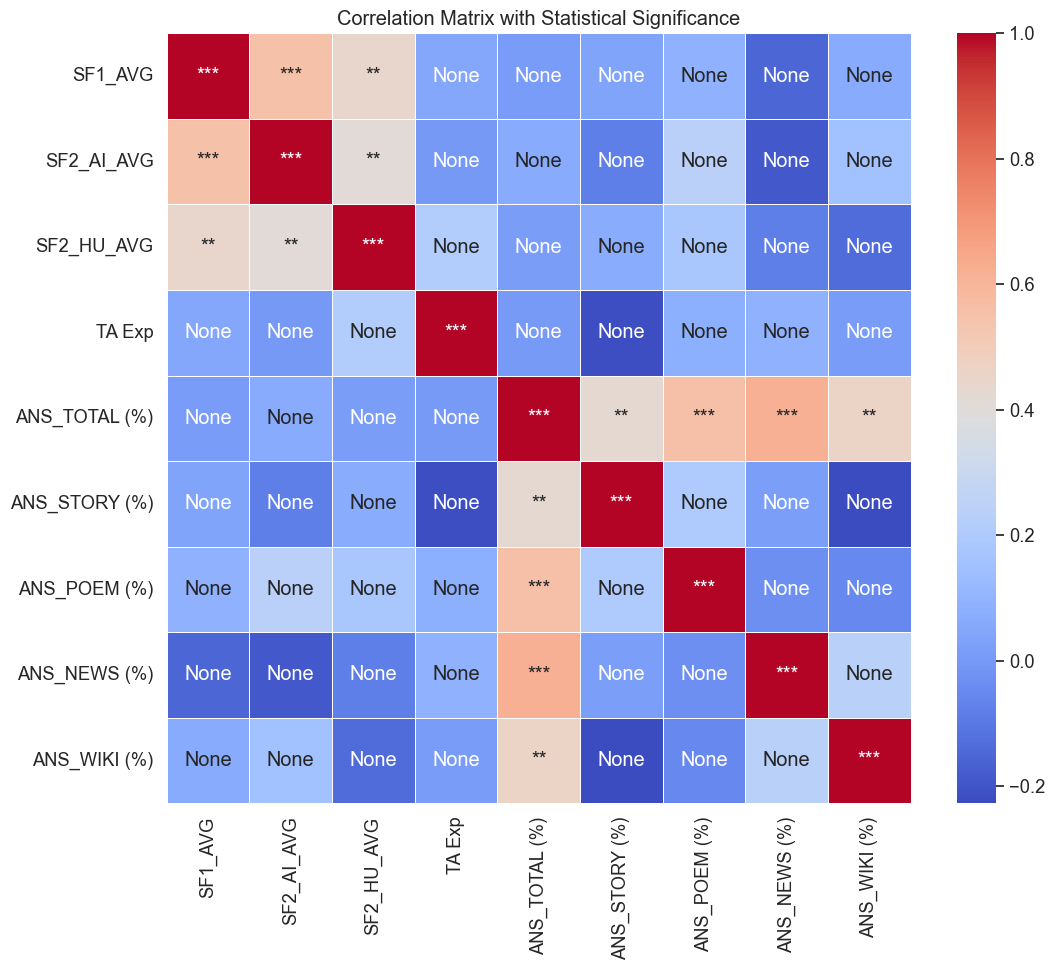

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import ttest_1samp

rho = df[data_cols].corr()

pval = df[data_cols].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)

significance = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x <= t]))

coefficients = rho.applymap(lambda x: float(x))
significance_indicators = significance.applymap(lambda x: x[-3:] if x else None)

plt.figure(figsize=(12, 10))
sns.set(font_scale=1.2)
sns.heatmap(coefficients, annot=significance_indicators, cmap='coolwarm', fmt='', linewidths=.5)
plt.title('Correlation Matrix with Statistical Significance')
plt.show()




